In [28]:
import sys
BIN = '../../'
sys.path.append(BIN)
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import time
import datetime

import torch
import torch.nn as nn
# import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset

import my_matplotlib_style as ms

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
from fastai import train as tr

from my_nn_modules import AE_3D_50_no_last_bias, AE_big_no_last_bias, AE_big, AE_3D_50, AE_3D_50_bn_drop, AE_3D_50cone, AE_3D_100, AE_3D_100_bn_drop, AE_3D_100cone_bn_drop, AE_3D_200, AE_3D_200_bn_drop, AE_3D_500cone_bn
from my_nn_modules import get_data, RMSELoss, plot_activations

In [29]:
!pwd

/Users/ericwulff/Documents/LTH/Examensarbete/lth_thesis_project/jet_by_jet_compression/split_data_training


In [30]:
path_to_data = '../../../data/split_data/'

save_dict = {}

module = AE_big
module_string = str(module).split("'")[1].split(".")[1]

loss_func = nn.MSELoss()
loss = nn.MSELoss()

In [31]:
def get_db_mean_std(data_nbr, norm_nbr):
    ii = data_nbr
    kk = norm_nbr
    # Load data
    train = pd.read_pickle(path_to_data + 'sub_train_%d' % ii)
    test = pd.read_pickle(path_to_data + 'sub_test_%d' % ii)
    train = train.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)
    train_norm = pd.read_pickle(path_to_data + 'sub_train_%d' % kk)
    test_norm = pd.read_pickle(path_to_data + 'sub_test_%d' % kk)

    # Normalize
    train_mean = train_norm.mean()
    train_std = train_norm.std()

    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std

    train_x = train
    test_x = test
    train_y = train_x  # y = x since we are training an AE
    test_y = test_x

    # Create DataBunch
    bs = 1024
    train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
    valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))
    train_dl, valid_dl = get_data(train_ds, valid_ds, bs=bs)
    db = basic_data.DataBunch(train_dl, valid_dl)
    return db, train, test, train_mean, train_std

In [32]:
db, train, test, mean, std = get_db_mean_std(0, 0)

In [33]:
train

,pT,eta,phi,E
0,0.694172,0.564042,-0.561951,-0.484403
1,1.484320,-0.623214,-1.349161,-0.382450
2,1.132641,-1.371095,0.413178,0.779141
3,-1.532017,2.088569,-0.988543,1.244430
4,-1.035388,-0.708669,0.151817,-0.566047
...,...,...,...,...
155027,-1.085752,0.598677,0.933753,-0.603058
155028,-0.838328,1.154052,-0.925095,-0.297706
155029,-0.606507,-1.396904,0.416166,0.124843
155030,1.444165,0.520731,0.214423,-0.452300


In [34]:
learn = basic_train.Learner(data=db, model=module(), loss_func=loss_func, bn_wd=bn_wd, true_wd=true_wd)
learn.load(module_string + '_subtrain_%d' % 0)
learn.model.eval()

AE_big(
  (en1): Linear(in_features=4, out_features=8, bias=True)
  (en2): Linear(in_features=8, out_features=6, bias=True)
  (en3): Linear(in_features=6, out_features=4, bias=True)
  (en4): Linear(in_features=4, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=4, bias=True)
  (de2): Linear(in_features=4, out_features=6, bias=True)
  (de3): Linear(in_features=6, out_features=8, bias=True)
  (de4): Linear(in_features=8, out_features=4, bias=True)
  (tanh): Tanh()
)

In [35]:
learn.loss_func

MSELoss()

In [244]:
learn.data.valid_ds[0]

(tensor([-2.0696,  0.5840,  1.6220, -0.6789]),
 tensor([-2.0696,  0.5840,  1.6220, -0.6789]))

In [245]:
learn.validate(dl=learn.data.valid_dl)

[0.0006899792]

In [246]:
learn.validate(dl=learn.data.train_dl)

[0.0006813574]

In [247]:
mean.values

array([ 4.484267e+01, -2.103853e-02,  1.304865e-02,  3.243336e+02], dtype=float32)

In [11]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def validate(learn, dl):
    for batch in dl:
        model = learn.model
        losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(val_loss)
        return val_loss
    
def get_unnormalized_reconstructions(model, df, train_mean, train_std, idxs=None):
    if idxs is not None:
        data = torch.tensor(df[idxs[0]:idxs[1]].values)
    else:
        data = torch.tensor(df.values)
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    return pred, data

In [249]:
validate(learn, learn.data.valid_dl)

0.0006899791656986553


0.0006899791656986553

In [250]:
validate(learn, learn.data.train_dl)

0.0006813573885672619


0.0006813573885672619

In [251]:
pred, data = get_unnormalized_reconstructions(model=learn.model, df=train, train_mean=mean, train_std=std)
pred = torch.tensor(pred)

In [252]:
loss(input=data, target=pred)

tensor(58.9501)

In [253]:
res = pred - data

In [254]:
res = res.numpy()

In [255]:
np.sum(res**2) / (res.shape[0] * res.shape[1])

58.950100624387225

In [24]:
# Figures setup
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

0.015617128603852037
Unnormalized loss: 2177.619141



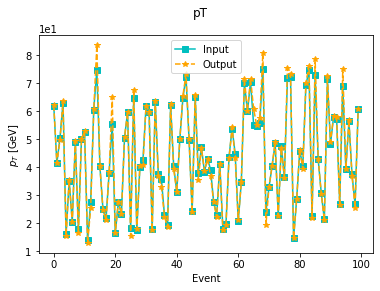

0.011407027821846575
Unnormalized loss: 3529.668701



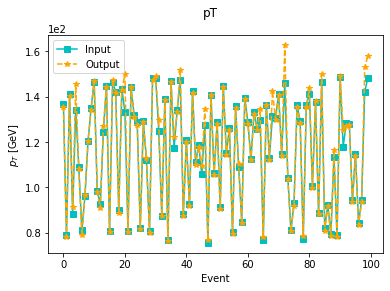

0.0022087308094461966
Unnormalized loss: 264.240387



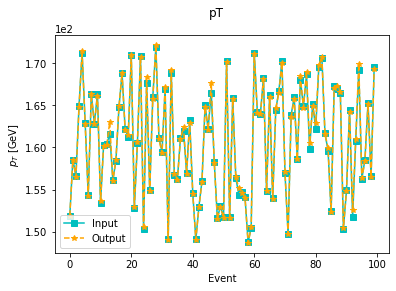

0.0005612103332662026
Unnormalized loss: 68.584625



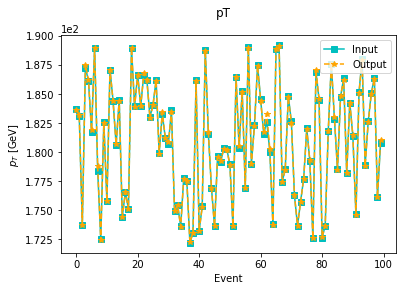

0.00016615885747749568
Unnormalized loss: 15.107093



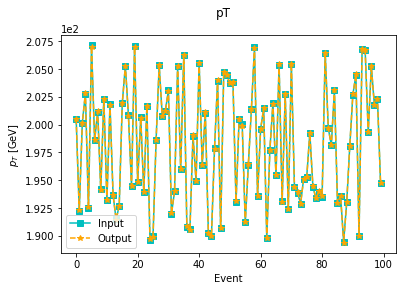

0.00029221527676364387
Unnormalized loss: 38.645367



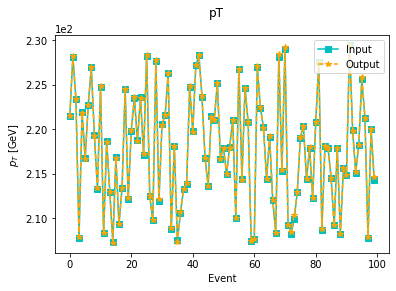

0.0003872504792392522
Unnormalized loss: 61.725883



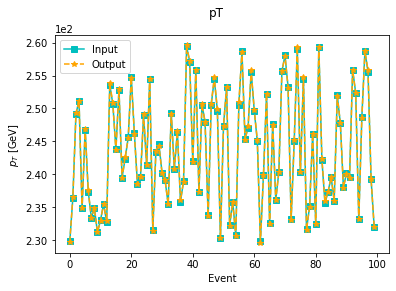

0.0008606369168029486
Unnormalized loss: 170.731339



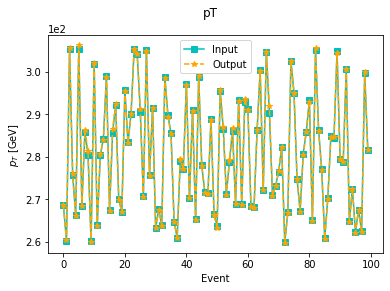

0.0032105465171657498
Unnormalized loss: 654.665955



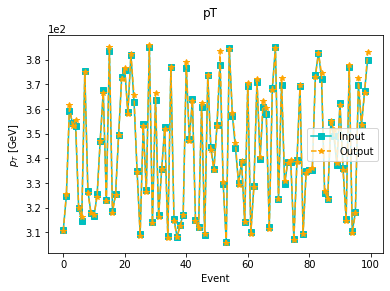

0.07158612686368117
Unnormalized loss: 14337.534180



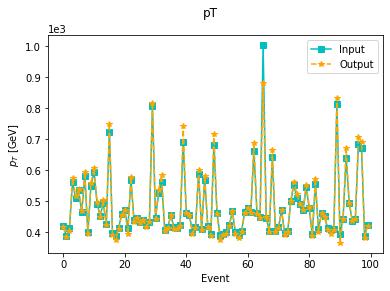

In [25]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
N = 10
kk = 4
db, train, test, mean, std = get_db_mean_std(kk, kk)
learn = basic_train.Learner(data=db, model=module(), loss_func=loss_func, bn_wd=bn_wd, true_wd=true_wd)
learn.load(module_string + '_subtrain_%d' % kk)
learn.model.eval()
for ii in np.arange(N):
    db, train, test, mean, std = get_db_mean_std(ii, ii)
    dl = db.train_dl
    validate(learn, dl)
    pred, data = get_unnormalized_reconstructions(model=learn.model, df=train, train_mean=mean, train_std=std)
    pred = torch.tensor(pred)
    unnorm_loss = loss(input=data, target=pred)
    print('Unnormalized loss: %f\n' % unnorm_loss)
    # Plot input on top of output
    idxs = (0, 100)  # Choose events to compare
    pred, data = get_unnormalized_reconstructions(model=learn.model, df=train, train_mean=mean, train_std=std, idxs=idxs)
    for pp in np.arange(1):
        plt.figure()
        plt.plot(data[:, pp], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
        plt.plot(pred[:, pp], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
        plt.suptitle(train.columns[pp])
        plt.xlabel('Event')
        plt.ylabel(variable_list[pp] + ' ' + unit_list[pp])
#        plt.ylim(bottom=0, top=400)
        plt.legend()
        ms.sciy()
        fig_name = 'plot_%s' % train.columns[pp]
        plt.show()

173.97483088924787
Unnormalized loss: 60861.367188



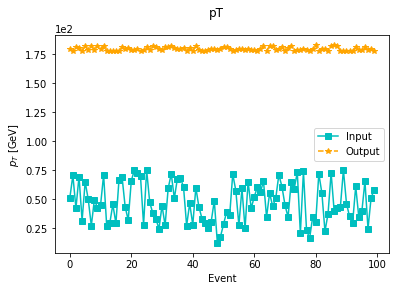

44.668138398616776
Unnormalized loss: 112896.562500



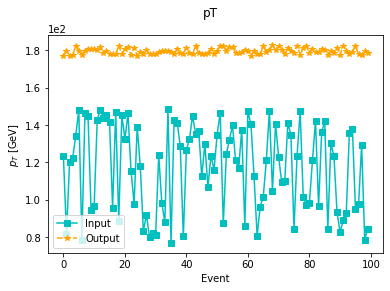

4.0775592657451725
Unnormalized loss: 28716.634766



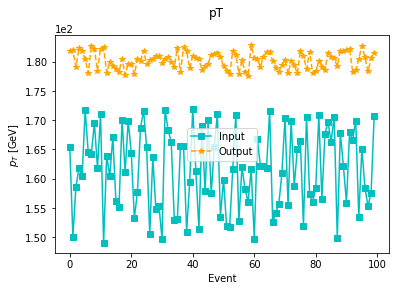

0.20299529378164036
Unnormalized loss: 5362.960938



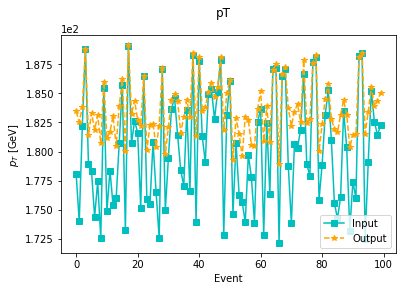

0.00016615885698189405
Unnormalized loss: 15.107093



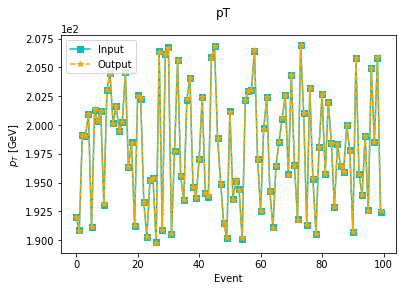

0.5163835673452414
Unnormalized loss: 47263.558594



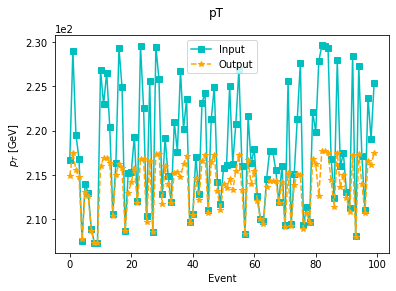

9.050886973156588
Unnormalized loss: 351910.687500



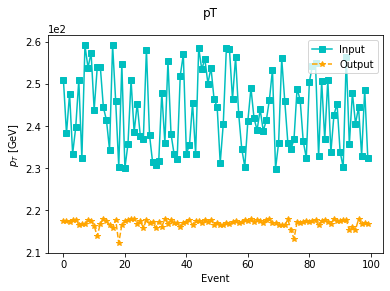

42.500314488611
Unnormalized loss: 297320.625000



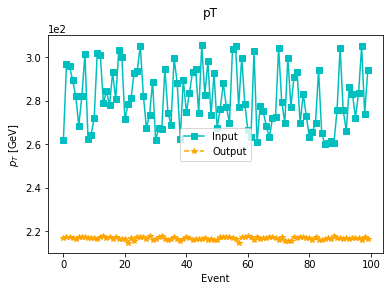

164.96223178530659
Unnormalized loss: 152578.531250



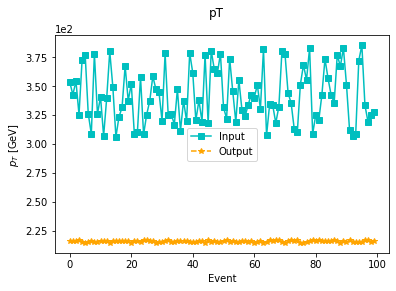

751.7992533459322
Unnormalized loss: 110806.523438



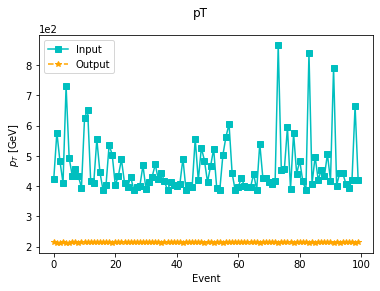

In [26]:
N = 10
kk = 4
db, train, test, mean, std = get_db_mean_std(kk, kk)
learn = basic_train.Learner(data=db, model=module(), loss_func=loss_func, bn_wd=bn_wd, true_wd=true_wd)
learn.load(module_string + '_subtrain_%d' % kk)
learn.model.eval()
for ii in np.arange(N):
    db, train, test, mean, std = get_db_mean_std(ii, kk)
    dl = db.train_dl
    validate(learn, dl)
    pred, data = get_unnormalized_reconstructions(model=learn.model, df=train, train_mean=mean, train_std=std)
    pred = torch.tensor(pred)
    unnorm_loss = loss(input=data, target=pred)
    print('Unnormalized loss: %f\n' % unnorm_loss)
    # Plot input on top of output
    idxs = (0, 100)  # Choose events to compare
    pred, data = get_unnormalized_reconstructions(model=learn.model, df=train, train_mean=mean, train_std=std, idxs=idxs)

    for pp in np.arange(1):
        plt.figure()
        plt.plot(data[:, pp], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
        plt.plot(pred[:, pp], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
        plt.suptitle(train.columns[pp])
        plt.xlabel('Event')
        plt.ylabel(variable_list[pp] + ' ' + unit_list[pp])
#        plt.ylim(bottom=0, top=400)
        plt.legend()
        ms.sciy()
        fig_name = 'plot_%s' % train.columns[pp]
        plt.show()
